<a href="https://colab.research.google.com/github/Ying-Yuan07/TensorFlowLearn/blob/main/%E8%88%AA%E7%8F%AD%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

values original:

[[86.0 -11 -9.0 1020.0 'SE' 124.71 22 0]
 [70.0 -11 -9.0 1020.0 'SE' 127.84 23 0]
 [61.0 -11 -9.0 1021.0 'cv' 0.89 24 0]
 [53.0 -11 -9.0 1022.0 'cv' 1.78 25 0]
 [71.0 -10 -9.0 1022.0 'NW' 4.02 26 0]
 [72.0 -11 -10.0 1023.0 'NW' 7.15 27 0]
 [76.0 -11 -9.0 1023.0 'NW' 11.17 0 0]
 [73.0 -12 -11.0 1023.0 'NW' 14.3 0 0]
 [79.0 -14 -12.0 1023.0 'NW' 16.09 0 0]
 [58.0 -16 -9.0 1023.0 'NW' 21.9 0 0]]
values encoded:

[[ 8.6000e+01 -1.1000e+01 -9.0000e+00  1.0200e+03  2.0000e+00  1.2471e+02
   2.2000e+01  0.0000e+00]
 [ 7.0000e+01 -1.1000e+01 -9.0000e+00  1.0200e+03  2.0000e+00  1.2784e+02
   2.3000e+01  0.0000e+00]
 [ 6.1000e+01 -1.1000e+01 -9.0000e+00  1.0210e+03  3.0000e+00  8.9000e-01
   2.4000e+01  0.0000e+00]
 [ 5.3000e+01 -1.1000e+01 -9.0000e+00  1.0220e+03  3.0000e+00  1.7800e+00
   2.5000e+01  0.0000e+00]
 [ 7.1000e+01 -1.0000e+01 -9.0000e+00  1.0220e+03  1.0000e+00  4.0200e+00
   2.6000e+01  0.0000e+00]
 [ 7.2000e+01 -1.1000e+01 -1.0000e+01  1.0230e+03  1.0000e+00  7

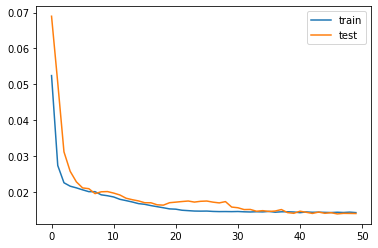

Test RMSE: 26.455


In [12]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd

"""
本文是LSTM多元预测
用3个步长的数据预测1个步长的数据
包含：
对数据进行缩放，缩放格式为n行*8列，因为数据没有季节性，所以不做差分
对枚举列（风向）进行数字编码
构造3->1的监督学习数据
构造网络开始预测
将预测结果重新拼接为n行*8列数据
数据逆缩放，求RSME误差
"""
pd.set_option('display.max_columns',1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

# 转换成监督数据，四列数据，3->1，三组预测一组
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] #列数
    df = DataFrame(data) #用归一化之后的excel数据构造 DataFrame
    cols, names = list(), list()#创建空list
    # input sequence (t-n, ... t-1)
    # 将3组输入数据依次向下移动3，2，1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
    	cols.append(df.shift(-i))
    	if i == 0:
    		names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    	else:
    		names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有四块经过下移后的数据(即：df(-3),df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    print(agg)
    # 删除NaN值列
    if dropnan:
    	agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('./sample_data/pollution.csv', header=0, index_col=0)
values = dataset.values
print("values original:\n")
print(values[40:50,:])

# 对“风向”列进行整数编码
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
print("values encoded:\n")
print(values[40:50,:])

# 标准化/放缩 特征值在（0,1）之间
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print("values scaled:\n")
print(scaled[40:50,:])

# 用3小时数据预测一小时数据，8个特征值
n_hours = 3
n_features = 8
# 构造一个3->1的监督学习型数据
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
# 用一年的数据来训练
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
# 有32=(4*8)列数据，取前24=(3*8) 列作为X，倒数第8列=(第25列)作为Y
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# 将数据转换为3D输入，timesteps=3，3条数据预测1条 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# 设计网络
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 拟合网络
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# 执行预测
yhat = model.predict(test_X)
# 将数据格式化成 n行 * 24列
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# 将预测列据和后7列数据拼接，因后续逆缩放时，数据形状要符合 n行*8列 的要求
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
# 对拼接好的数据进行逆缩放
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
# 将真实列据和后7列数据拼接，因后续逆缩放时，数据形状要符合 n行*8列 的要求
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
# 对拼接好的数据进行逆缩放
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# 计算RMSE误差值
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)